# ML from scratch: Stable Diffusion, Day 2

### [Binxu Wang](https://scholar.harvard.edu/binxuw) and [John Vastola](https://twitter.com/johnjvastola)

<p align="center">
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/astro.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/ballerina_chasing_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/lovely_cat.png?raw=true" alt="drawing" width="150"/>
<img src="https://github.com/DrugowitschLab/ML-from-scratch-seminar/blob/master/StableDiffusion/images/turtle3.png?raw=true" alt="drawing" width="150"/>
</p>

On the first day, we went over the various components necessary to make an effective diffusion generative model like [Stable Diffusion](https://ommer-lab.com/research/latent-diffusion-models/).

As a reminder, they are:

- Method of learning to generate new stuff (forward/reverse diffusion)
- Way to link text and images (text-image representation model like [CLIP](https://github.com/openai/CLIP))
- Way to compress images (autoencoder)
- Way to add in good inductive biases (U-net architecture + self/cross-attention)

In today's session, you will implement pieces of each of the above, and by the end have a working Stable-Diffusion-like model.

In particular, you will implement parts of:

- **basic 1D forward/reverse diffusion**
- **a U-Net architecture for working with images**
- **the loss associated with learning the score function**
- **an attention model for conditional generation**
- **an autoencoder**

We need a reasonably small dataset so that training does not take forever, so we will be working with [MNIST](https://en.wikipedia.org/wiki/MNIST_database), a set of 28x28 images of handwritten 0-9 digits. By the end, our model should be able to take in a number prompt (e.g. "4") and output an image of the digit 4.

----------------

In [1]:
!pip install einops
!pip install lpips

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

import matplotlib.pyplot as plt

from torchvision.utils import make_grid


-------------------------------------------

## 1. Basic forward/reverse diffusion

This section reviews material from the [previous MLFS seminar](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/DiffusionGenerativeModels) on diffusion generative models. Skip this if you already know the basics!

The gist is that our generative model will work in the following way. We will take our training examples (e.g. images) and corrupt them with noise until they are unrecognizable. Then we will learn to `denoise' them, and potentially turn pure noise into something similar to what we started with.



### Basic forward diffusion

**Let's start with forward diffusion.** In the simplest case, the relevant diffusion equation is
\begin{equation}
\begin{split}
x(t + \Delta t) = x(t) + \sigma(t) \sqrt{\Delta t} \ r
\end{split}
\end{equation}
where $\sigma(t) > 0$ is the 'noise strength', $\Delta t$ is the step size, and $r \sim \mathcal{N}(0, 1)$ is a standard normal random variable. In essence, we repeatedly add normally-distributed noise to our sample. Often, the noise strength $\sigma(t)$ is chosen to depend on time (i.e. it gets higher as $t$ gets larger).

**Implement the missing part of 1D forward diffusion**.

*Hint: You can use `np.random.randn()` to generate random numbers.*

In [16]:
# Simulate forward diffusion for N steps.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  t0: initial time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = t0 + np.arange(nsteps + 1)*dt

  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(t[i], nsteps)
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + random_normal * noise_strength
    #####################################
  return x, t


# Example noise strength function: always equal to 1
def noise_strength_constant(t, nsteps):
  return 1

import math
def noise_strength_linear(t, nsteps):
  return 0.1 + (0.5 - 0.1) * (t / nsteps)

def noise_strength_cosine(t, nsteps):
  alpha = math.cos((t / nsteps) * (math.pi / 2))
  return 0.1 + (0.5 - 0.1) * (1 - alpha)

See if it works by running the code below.

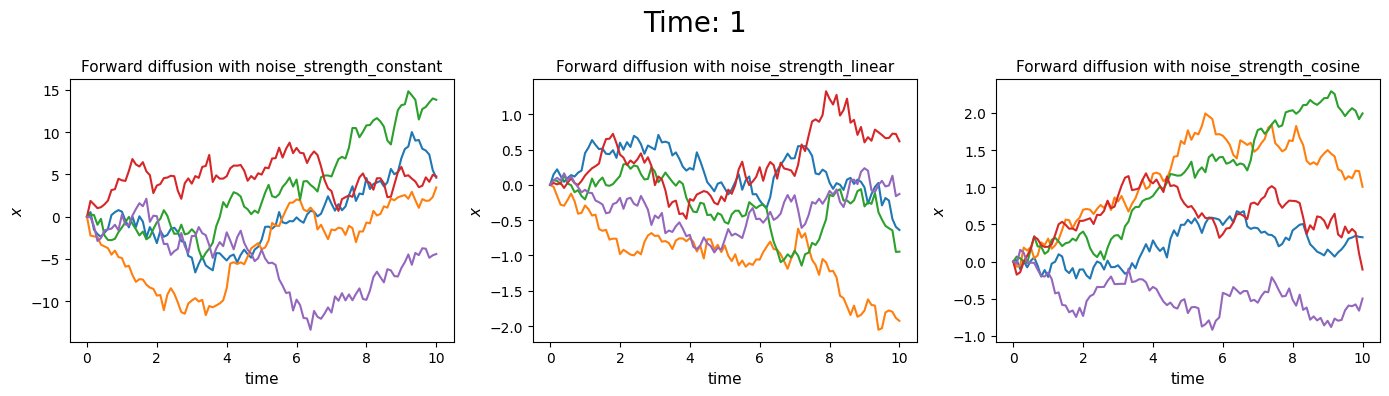

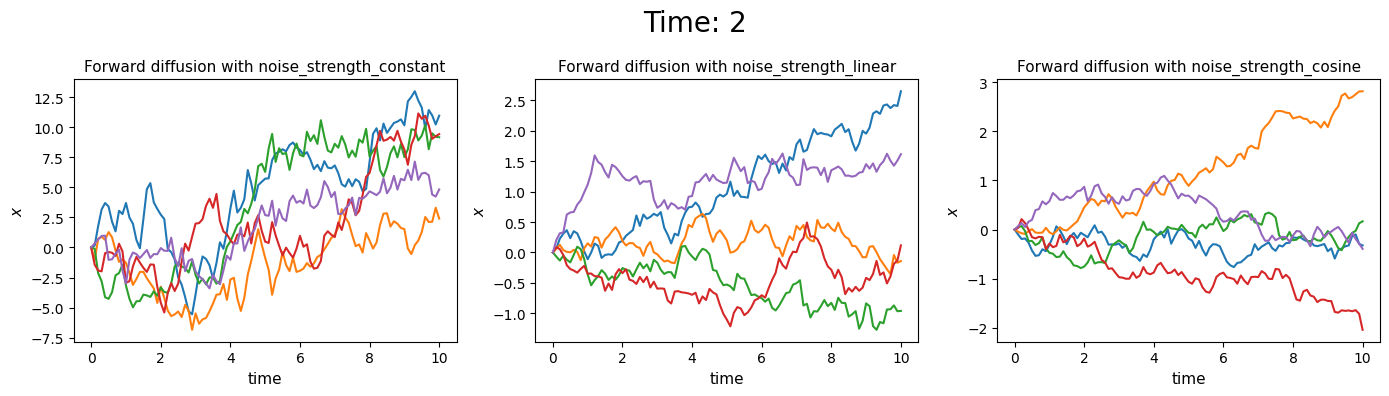

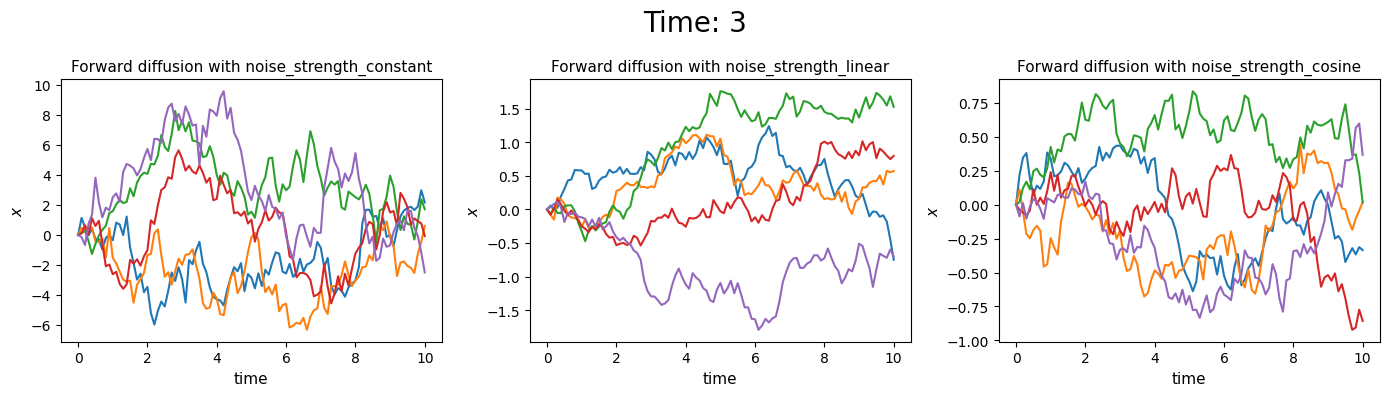

In [26]:
num = 3
nsteps = 100
t0 = 0
dt = 0.1
x0 = 0

noise_dict = {
    'noise_strength_constant': noise_strength_constant,
    'noise_strength_linear': noise_strength_linear,
    'noise_strength_cosine': noise_strength_cosine,
}

for n in range(num):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    for idx, noise_type in enumerate(noise_dict):
        num_tries = 5
        for i in range(num_tries):
            x, t = forward_diffusion_1D(x0, noise_dict[noise_type], t0, nsteps, dt)
            axs[idx].plot(t, x)
        axs[idx].set_title(f'Forward diffusion with {noise_type}', fontsize=11)
        axs[idx].set_xlabel('time', fontsize=11)
        axs[idx].set_ylabel('$x$', fontsize=11)

    fig.suptitle(f'Time: {n+1}', fontsize=20)
    plt.tight_layout()
    plt.show()

### Basic reverse diffusion

We can reverse this diffusion process by a similar-looking update rule:
\begin{equation}
x(t + \Delta t) = x(t) + \sigma(T - t)^2 \frac{d}{dx}\left[ \log p(x, T-t) \right] \Delta t + \sigma(T-t) \sqrt{\Delta t} \ r
\end{equation}
where
\begin{equation}
s(x, t) := \frac{d}{dx} \log p(x, t)
\end{equation}
is called the **score function**. If we know this function, we can reverse the forward diffusion and turn noise into what we started with.

If our initial sample is always just one point at $x_0 = 0$, and the noise strength is constant, then the score function is exactly equal to
\begin{equation}
s(x, t) = - \frac{(x - x_0)}{\sigma^2 t} = - \frac{x}{\sigma^2 t} \ .
\end{equation}

**Implement the missing part of 1D reverse diffusion**. You will test it with the above score function.

*Hint: You can use `np.random.randn()` to generate random numbers.*

In [33]:
# Simulate forward diffusion for N steps.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
  """x0: initial sample value, scalar
  noise_strength_fn: function of time, outputs scalar noise strength
  score_fn: score function
  T: final time
  nsteps: number of diffusion steps
  dt: time step size
  """

  # Initialize trajectory
  x = np.zeros(nsteps + 1); x[0] = x0
  t = np.arange(nsteps + 1)*dt

  # Perform many Euler-Maruyama time steps
  for i in range(nsteps):
    noise_strength = noise_strength_fn(T - t[i], nsteps)
    score = score_fn(x[i], 0, noise_strength, T-t[i])
    ############ YOUR CODE HERE (2 lines)
    random_normal = np.random.randn()
    x[i+1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)
    #####################################
  return x, t


def score_simple(x, x0, noise_strength, t):
  score = - (x-x0)/((noise_strength**2)*t)
  return score

Run the cell below to see if your implementation works.

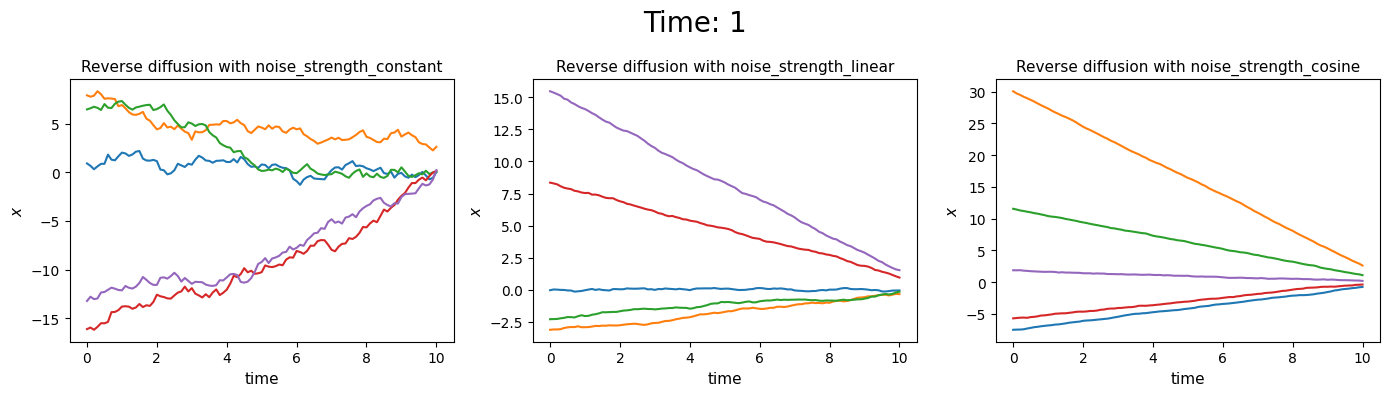

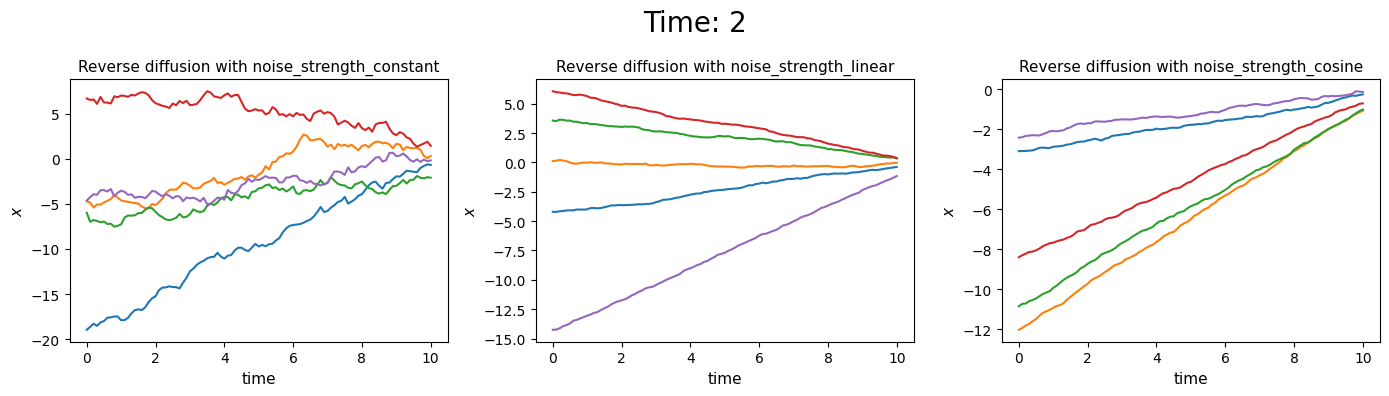

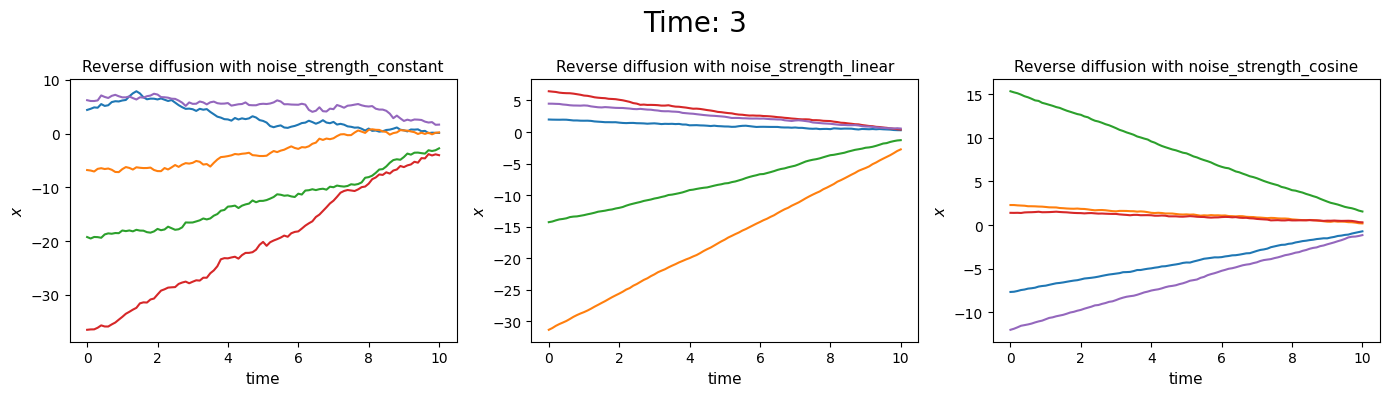

In [40]:
num = 3
nsteps = 100
t0 = 0
dt = 0.1
score_fn = score_simple
x0 = 0
T = 11

noise_dict = {
    'noise_strength_constant': noise_strength_constant,
    'noise_strength_linear': noise_strength_linear,
    'noise_strength_cosine': noise_strength_cosine,
}

for n in range(num):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4))

    for idx, noise_type in enumerate(noise_dict):
        num_tries = 5
        for i in range(num_tries):
            x0 = np.random.normal(loc=0, scale=T)
            x, t = reverse_diffusion_1D(x0, noise_dict[noise_type], score_fn, T, nsteps, dt)
            axs[idx].plot(t, x)
        axs[idx].set_title(f'Reverse diffusion with {noise_type}', fontsize=11)
        axs[idx].set_xlabel('time', fontsize=11)
        axs[idx].set_ylabel('$x$', fontsize=11)

    fig.suptitle(f'Time: {n+1}', fontsize=20)
    plt.tight_layout()
    plt.show()


### Basic score function learning

In practice, we don't already know the score function; instead, we have to learn it. One way to learn it is to train a neural network to `denoise' samples via the denoising objective
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0)}\left[ \ \Vert s(x_{noised}, t) \sigma^2(t) + (x_{noised} - x_0)  \Vert^2_2  \ \right]
\end{equation}
where $p_0(x_0)$ is our target distribution (e.g. pictures of cats and dogs), and where $x_{noised}$ is the target distribution sample $x_0$ after one forward diffusion step, i.e. $x_{noised} - x_0$ is just a normally-distributed random variable.

Here's another way of writing the same thing, which is closer to the actual implementation. By substituting
\begin{equation}
x_{noised} = x_0 + \sigma(t) \epsilon, \; \epsilon\sim \mathcal N(0,I)
\end{equation}
We got this objective function
\begin{equation}
J := \mathbb{E}_{t\in (0, T), x_0 \sim p_0(x_0), \epsilon \sim \mathcal N(0,I)}\left[ \ \Vert s(x_0 + \sigma(t) \epsilon, t) \sigma(t) + \epsilon  \Vert^2_2  \ \right]
\end{equation}
We will implement this for you. But it's good to understand the intuition: we are learning to predict **how much noise was added to each part of our sample**. We should be able to do this well at every time $t$ in the diffusion process, and for every $x_0$ in our original (dogs/cats/etc) distribution.

---------------------